# This notebook uses the Inception-ResNet v2 architecture. The stem has been modified to accommodate for 64x64 images.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import keras
import os
import tensorboard
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Input, concatenate, add, Activation, BatchNormalization, Lambda
from tensorflow.keras.optimizers import Adam
from tensorboard.plugins.hparams import api as hp

from photoz_utils import *
from DataMakerPlus import *

2023-09-01 11:23:03.791862: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-01 11:23:04.351039: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-09-01 11:23:04.351090: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-09-01 11:23:04.351095: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
GB_LIMIT = 17

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(GB_LIMIT*1000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
IMAGE_SHAPE = (5, 64, 64)
BATCH_SIZE = 256
NUM_EPOCHS = 100
LEARNING_RATE = 0.0001
Z_MAX = 4
hparams = {
    'batch_size': BATCH_SIZE,
    'num_epochs': NUM_EPOCHS,
    'learning_rate': LEARNING_RATE,
    'z_max': Z_MAX
}

In [4]:
TRAIN_PATH = f'/data/HSC/HSC_v6/step3A/64x64_training_small.hdf5'
VAL_PATH = f'/data/HSC/HSC_v6/step3A/64x64_validation_small.hdf5'
TEST_PATH = f'/data/HSC/HSC_v6/step3A/64x64_testing_small.hdf5'

In [5]:
gen_args = {
    'image_key': 'image',
    'numerical_keys': None,
    'y_key': 'specz_redshift',
    'scaler': True,
    'labels_encoding': False,
    'batch_size': hparams['batch_size'],
    'shuffle': False}

In [6]:
train_gen = HDF5DataGenerator(TRAIN_PATH, mode='train', **gen_args)
val_gen = HDF5DataGenerator(VAL_PATH, mode='train', **gen_args)
test_gen = HDF5DataGenerator(TEST_PATH, mode='test', **gen_args)

In [7]:
import keras.backend as K

def calculate_loss(z_photo, z_spec):
    """
    HSC METRIC. Returns an array. Loss is accuracy metric defined by HSC, meant
    to capture the effects of bias, scatter, and outlier all in one. This has
    uses for both point and density estimation.
    z_photo: array
        Photometric or predicted redshifts.
    z_spec: array
        Spectroscopic or actual redshifts.
    """
    dz = delz(z_photo, z_spec)
    gamma = 0.15
    denominator = 1.0 + K.square(dz/gamma)
    loss = 1 - 1.0 / denominator
    return loss

In [8]:
def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1,1)):
    out = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, data_format='channels_first')(x)
    out = BatchNormalization(axis=1, scale=False)(out)
    out = Activation('relu')(out)
    return out

In [9]:
def inc_block_a(x):
    original_in = x

    branch1 = conv2d_bn(x, 32, 1, 1)

    branch2 = conv2d_bn(x, 32, 1, 1)
    branch2 = conv2d_bn(branch2, 32, 3, 3)

    branch3 = conv2d_bn(x, 32, 1, 1)
    branch3 = conv2d_bn(branch3, 48, 3, 3)
    branch3 = conv2d_bn(branch3, 64, 3, 3)

    inc_block_out = concatenate([branch1, branch2, branch3], axis=1)
    inc_block_out = Conv2D(384, (1,1), strides=(1,1), padding='same', data_format='channels_first')(inc_block_out)
    inc_block_out = Lambda(lambda x: x * 0.1)(inc_block_out)
    out = add([original_in, inc_block_out])
    out = Activation('relu')(out)

    return out

In [10]:
def reduction_block_a(x):
    branch1 = conv2d_bn(x, 384, 3, 3, strides=(2,2), padding='valid')

    branch2 = conv2d_bn(x, 256, 1, 1)
    branch2 = conv2d_bn(branch2, 256, 3, 3)
    branch2 = conv2d_bn(branch2, 384, 3, 3, strides=(2,2), padding='valid')

    branch3 = MaxPooling2D((3,3), strides=(2,2), padding='valid', data_format='channels_first')(x)

    out = concatenate([branch1, branch2, branch3], axis=1)
    return out

In [11]:
def inc_block_b(x):
    original_in = x

    branch1 = conv2d_bn(x, 192, 1, 1)

    branch2 = conv2d_bn(x, 128, 1, 1)
    branch2 = conv2d_bn(branch2, 160, 1, 7)
    branch2 = conv2d_bn(branch2, 192, 7, 1)

    inc_block_out = concatenate([branch1, branch2], axis=1)
    inc_block_out = Conv2D(1152, (1,1), strides=(1,1), padding='same', data_format='channels_first')(inc_block_out)
    inc_block_out = Lambda(lambda x: x * 0.1)(inc_block_out)
    out = add([original_in, inc_block_out])
    out = Activation('relu')(out)

    return out

In [12]:
def reduction_block_b(x):
    branch1 = conv2d_bn(x, 256, 1, 1)
    branch1 = conv2d_bn(branch1, 384, 3, 3, strides=(2,2), padding='valid')

    branch2 = conv2d_bn(x, 256, 1, 1)
    branch2 = conv2d_bn(branch2, 288, 3, 3)
    branch2 = conv2d_bn(branch2, 320, 3, 3, strides=(2,2), padding='valid')

    branch3 = MaxPooling2D((3,3), strides=(2,2), padding='valid', data_format='channels_first')(x)

    branch4 = conv2d_bn(x, 256, 1, 1)
    branch4 = conv2d_bn(branch4, 288, 3, 3, strides=(2,2), padding='valid')

    out = concatenate([branch1, branch2, branch3, branch4], axis=1)
    return out

In [13]:
def inc_block_c(x):
    original_in = x

    branch1 = conv2d_bn(x, 192, 1, 1)

    branch2 = conv2d_bn(x, 192, 1, 1)
    branch2 = conv2d_bn(branch2, 224, 1, 3)
    branch2 = conv2d_bn(branch2, 256, 3, 1)

    inc_block_out = concatenate([branch1, branch2], axis=1)
    inc_block_out = Conv2D(2144, (1,1), strides=(1,1), padding='same', data_format='channels_first')(inc_block_out)
    inc_block_out = Lambda(lambda x: x * 0.1)(inc_block_out)
    out = add([original_in, inc_block_out])
    out = Activation('relu')(out)

    return out

In [14]:
def stem(x):
    out = conv2d_bn(x, 32, 3, 3)
    out = conv2d_bn(out, 32, 3, 3)
    out = conv2d_bn(out, 64, 3, 3)

    branch1 = MaxPooling2D((3, 3), strides=(2,2), padding='same', data_format='channels_first')(out)
    branch2 = conv2d_bn(out, 96, 3, 3, strides=(2,2))
    out = concatenate([branch1, branch2], axis=1)

    branch1 = conv2d_bn(out, 64, 1, 1)
    branch1 = conv2d_bn(branch1, 96, 3, 3)
    branch2 = conv2d_bn(out, 64, 1, 1)
    branch2 = conv2d_bn(branch2, 64, 7, 1)
    branch2 = conv2d_bn(branch2, 64, 1, 7)
    branch2 = conv2d_bn(branch2, 96, 3, 3)
    out = concatenate([branch1, branch2], axis=1)

    out = conv2d_bn(out, 384, 3, 3)

    return out

In [15]:
input_ = Input(shape=IMAGE_SHAPE)
x = stem(input_)

x = inc_block_a(x)
x = inc_block_a(x)
x = reduction_block_a(x)
x = inc_block_b(x)
x = inc_block_b(x)
x = inc_block_b(x)
x = inc_block_b(x)
x = reduction_block_b(x)
x = inc_block_c(x)
x = inc_block_c(x)
x = GlobalAveragePooling2D(data_format='channels_first')(x)
x = Dropout(0.2)(x)
x = Dense(1)(x)

model = Model(input_, x)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 64, 64)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 64, 64)   1472        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 64, 64)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 64, 64)   0           ['batch_normalization[0][0]']

In [17]:
model.compile(optimizer=Adam(learning_rate=hparams['learning_rate']), loss='mse', metrics='mse')

In [18]:
model_name = 'inception_resnet_2_64x64_small_v1'

checkpoint_filepath = f'/data2/models/{model_name}/checkpoints/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_filepath)
log_dir = os.path.join('/data2/logs/', model_name)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_freq='epoch',
    save_best_only=True,
    verbose=True)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

hparam_callback = hp.KerasCallback(log_dir, hparams)

In [19]:
model.fit(train_gen, batch_size=hparams['batch_size'], epochs=hparams['num_epochs'], shuffle=True, verbose=1, validation_data=val_gen, callbacks=[tensorboard_callback, model_checkpoint_callback, hparam_callback])

Epoch 1/100
40/40 [==============================] - ETA: 0s - loss: 1.4189 - mse: 1.4189
Epoch 1: loss improved from inf to 1.41890, saving model to /data2/models/inception_resnet_2_64x64_small_v1/checkpoints/cp.ckpt
40/40 [==============================] - 91s 1s/step - loss: 1.4189 - mse: 1.4189 - val_loss: 0.5757 - val_mse: 0.5757
Epoch 2/100
40/40 [==============================] - ETA: 0s - loss: 0.5413 - mse: 0.5413
Epoch 2: loss improved from 1.41890 to 0.54126, saving model to /data2/models/inception_resnet_2_64x64_small_v1/checkpoints/cp.ckpt
40/40 [==============================] - 44s 1s/step - loss: 0.5413 - mse: 0.5413 - val_loss: 0.5381 - val_mse: 0.5381
Epoch 3/100
40/40 [==============================] - ETA: 0s - loss: 0.5470 - mse: 0.5470
Epoch 3: loss did not improve from 0.54126
40/40 [==============================] - 41s 1s/step - loss: 0.5470 - mse: 0.5470 - val_loss: 0.5393 - val_mse: 0.5393
Epoch 4/100
40/40 [==============================] - ETA: 0s - loss: 0

In [20]:
model.load_weights(checkpoint_filepath) # model might be overfitting. train mse is lowering but val mse fluctuates

In [21]:
pred = model.predict(test_gen)

8/8 [==============================] - 3s 298ms/step


In [22]:
with h5py.File(TEST_PATH, 'r') as file:
    y_test = np.asarray(file['specz_redshift'][:])
    oid_test = np.asarray(file['object_id'][:])

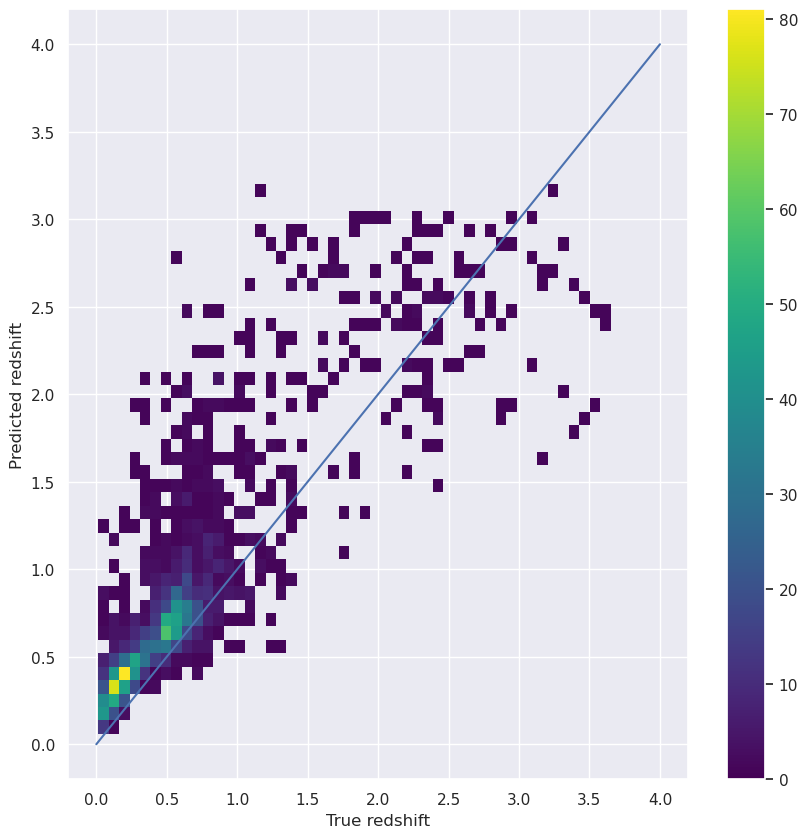

In [23]:
plot_predictions(np.ravel(pred), y_test)

In [24]:
metrics = get_point_metrics(pd.Series(np.ravel(pred)), pd.Series(y_test), binned=False)

In [25]:
metrics

,zspec_bin,count,L,bias_bw,bias_conv,scatter_bw,scatter_conv,outlier_bw,outlier_conv,mse
0,"(0.0, 4.0]",2000,0.456802,0.130006,0.134326,0.126929,0.10669,0.1135,0.461,0.166714


In [26]:
df = pd.DataFrame(pred, columns=['photoz'])
df['specz'] = pd.Series(y_test)
df['object_id'] = pd.Series(oid_test)
os.makedirs(f'/data2/predictions/{model_name}', exist_ok=True)
df.to_csv(f'/data2/predictions/{model_name}/testing_predictions.csv', index=False)
metrics.to_csv(f'/data2/predictions/{model_name}/testing_metrics.csv', index=False)